**Todas as cidades**

In [1]:
# Importando módulos internos
import geocov19_functions_results as fresults

# Importando módulos externos
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statistics import mean
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/mario/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil
#collection_cities_dates = db.cities_dates

In [3]:
def return_tokens(df, column):
    
    all_tokens = []

    for index, row in df.iterrows():
        tokens = row[column]
        for token in tokens:
            all_tokens.append(token)

    return all_tokens

In [4]:
#df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [5]:
city = 'Fortaleza'
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'city':city, 'score': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [6]:
len(df)

20509

In [7]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 10:17:46,user_location,Ceará,Fortaleza,RT @Miltonneves: Só piora. Isso não tá parecen...,-0.8693,pt
1,2020-02-02 11:16:39,user_location,Ceará,Fortaleza,RT @LeiaJaOnline: A notícia do falecimento foi...,-0.5994,pt
2,2020-02-02 11:44:30,user_location,Ceará,Fortaleza,RT @da_goiabeira: Passam a vida criticando a c...,-0.3612,pt
3,2020-02-02 12:14:23,user_location,Ceará,Fortaleza,RT @gazetadopovo: Primeira morte por coronavír...,-0.5994,pt
4,2020-02-02 12:58:19,user_location,Ceará,Fortaleza,RT @digital_explora: #CORONAVIRUS #CHINA/#WUHA...,0.0000,pt


Análises por período

Calculando datas de marcos de casos das 100 maiores cidades em quantidade de tweets:

- Seleciona cidades com períodos (sem casos, após 1º caso, após 1ª morte) de no mínimo 3 dias
- Seleciona cidades com datas de 1º caso e 1ª morte dentro do período da base (01/02/2020 a 01/05/2020)

In [8]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [9]:
top_cities = list(df.city.value_counts()[:100].index)
df_top_cities = df.loc[df['city'].isin(top_cities)]

In [10]:
from datetime import datetime
from datetime import timedelta

cities = df_top_cities.groupby('city')

cities_cases_date = []
initial = '2020-02-01'
final = '2020-05-01'
min_num_days = 3

for city in cities['city']:

    city = city[0]   
    
    df_cases_city = df_cases_brasil.query('city == "'+city+'"')
    df_cases_city = df_cases_city.reset_index()
    df_cases_city = df_cases_city.drop(columns=['index'])
    
    if (len(df_cases_city) > 0):
    
        # Data do primeiro caso 
        first_case = df_cases_city.loc[0, 'date']

        # Data da primeira morte
        result = df_cases_city.query('last_available_deaths != "0"')
        
        if (len(result) > 0):
            first_death = df_cases_city.loc[min(result.index), 'date']
            
            initial_date = datetime.strptime(initial, '%Y-%m-%d')
            first_case_date = datetime.strptime(first_case, '%Y-%m-%d')
            first_death_date = datetime.strptime(first_death, '%Y-%m-%d')
            final_date = datetime.strptime(final, '%Y-%m-%d')
            
            total_days1 = (first_case_date - initial_date).days
            total_days2 = (first_death_date - first_case_date).days
            total_days3 = (final_date - first_death_date).days
            
            if (total_days1 > min_num_days and total_days2 > min_num_days and total_days3 > min_num_days):
                data = [city, first_case, first_death]
                cities_cases_date.append(data)

df_cities_cases_date = pd.DataFrame.from_dict(cities_cases_date)
df_cities_cases_date.columns = ['city', 'first_case_date', 'first_death_date']

df_cities_cases_date

,city,first_case_date,first_death_date
0,Fortaleza,2020-03-16,2020-03-26


**Análises por Período - Geral**

Calculando média de sentimentos totais por cidade, médias de sentimentos por período e palavras negativas e positivas utilizadas em cada período.

- Seleciona somente cidades que tenham no mínimo 300 tweets por período

In [11]:
periodo1_mean = []
periodo2_mean = []
periodo3_mean = []
total_mean = []

tokens_neg = []
tokens_neg1 = []
tokens_neg2 = []
tokens_neg3 = []

tokens_pos = []
tokens_pos1 = []
tokens_pos2 = []
tokens_pos3 = []

total_processed = 0
min_tweets = 100
max_tokens = 5

for index, row in df_cities_cases_date.iterrows():
    
    city = row['city']
    
    total_processed = total_processed + 1
    print('Processando', total_processed, 'de', len(df_cities_cases_date))
    
    df_city = df.query('city == "'+city+'"')
    
    df_periodo1 = df_city.query('created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case+' 00:00:00"')  
    df_periodo2 = df_city.query('created_at >= "'+first_case+' 00:00:00" and created_at < "'+first_death+' 00:00:00"')
    df_periodo3 = df_city.query('created_at >= "'+first_death+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
 
    num_tweets1 = len(df_periodo1)
    num_tweets2 = len(df_periodo2)
    num_tweets3 = len(df_periodo3)
    
    if (num_tweets1 >= min_tweets and num_tweets2 >= min_tweets and num_tweets3 >= min_tweets):
        
        df_city_mean = mean(df_city['score'])
        total_mean.append(df_city_mean)
        
        df_periodo1_mean = mean(df_periodo1['score'])
        periodo1_mean.append(df_periodo1_mean)
        
        df_periodo2_mean = mean(df_periodo2['score'])
        periodo2_mean.append(df_periodo2_mean)
        
        df_periodo3_mean = mean(df_periodo3['score'])
        periodo3_mean.append(df_periodo3_mean)
    
        start = df_city['score'].describe()['min']
        end = df_city['score'].describe()['25%']

        tokens_city_neg = fresults.return_max_tokens_from_interval(df_city, start, end, max_tokens)
        tokens_city_neg1 = fresults.return_max_tokens_from_interval(df_periodo1, start, end, max_tokens)
        tokens_city_neg2 = fresults.return_max_tokens_from_interval(df_periodo2, start, end, max_tokens)
        tokens_city_neg3 = fresults.return_max_tokens_from_interval(df_periodo3, start, end, max_tokens)

        tokens_neg.append(tokens_city_neg)
        tokens_neg1.append(tokens_city_neg1)
        tokens_neg2.append(tokens_city_neg2)
        tokens_neg3.append(tokens_city_neg3)

        start = df_city['score'].describe()['75%']
        end = df_city['score'].describe()['max']

        tokens_city_pos = fresults.return_max_tokens_from_interval(df_city, start, end, max_tokens)
        tokens_city_pos1 = fresults.return_max_tokens_from_interval(df_periodo1, start, end, max_tokens)
        tokens_city_pos2 = fresults.return_max_tokens_from_interval(df_periodo2, start, end, max_tokens)
        tokens_city_pos3 = fresults.return_max_tokens_from_interval(df_periodo3, start, end, max_tokens)

        tokens_pos.append(tokens_city_pos)
        tokens_pos1.append(tokens_city_pos1)
        tokens_pos2.append(tokens_city_pos2)
        tokens_pos3.append(tokens_city_pos3)
        
    else:
        df_cities_cases_date.drop(index)
    
df_cities_cases_date['total_mean'] = total_mean
df_cities_cases_date['periodo1_mean'] = periodo1_mean
df_cities_cases_date['periodo2_mean'] = periodo2_mean
df_cities_cases_date['periodo3_mean'] = periodo3_mean

df_cities_cases_date['tokens_neg'] = tokens_neg
df_cities_cases_date['tokens_neg1'] = tokens_neg1
df_cities_cases_date['tokens_neg2'] = tokens_neg2
df_cities_cases_date['tokens_neg3'] = tokens_neg3

df_cities_cases_date['tokens_pos'] = tokens_pos
df_cities_cases_date['tokens_pos1'] = tokens_pos1
df_cities_cases_date['tokens_pos2'] = tokens_pos2
df_cities_cases_date['tokens_pos3'] = tokens_pos3

Processando 1 de 1


In [12]:
len(df_cities_cases_date)

1

In [13]:
df_cities_cases_date.head()

,city,first_case_date,first_death_date,total_mean,periodo1_mean,periodo2_mean,periodo3_mean,tokens_neg,tokens_neg1,tokens_neg2,tokens_neg3,tokens_pos,tokens_pos1,tokens_pos2,tokens_pos3
0,Fortaleza,2020-03-16,2020-03-26,-0.05698,-0.024402,-0.04162,-0.065489,"[(brasil, 432), (bolsonaro, 416), (pessoas, 32...","[(brasil, 46), (presidente, 36), (pessoas, 31)...","[(bolsonaro, 76), (brasil, 46), (pessoas, 40),...","[(brasil, 340), (bolsonaro, 311), (mortos, 272...","[(brasil, 330), (saúde, 257), (dia, 231), (cas...","[(brasil, 37), (aqui, 32), (todos, 28), (anos,...","[(brasil, 39), (deus, 35), (casos, 35), (bolso...","[(brasil, 254), (saúde, 213), (dia, 183), (cas..."


***
**Análises**

10 cidades com **menores médias** de sentimentos

In [14]:
df_cities_neg = df_cities_cases_date.sort_values(by=['total_mean'], ascending=True)[:10]
df_cities_neg['city']

0    Fortaleza
Name: city, dtype: object

10 cidades com **maiores médias** de sentimentos

In [15]:
df_cities_pos = df_cities_cases_date.sort_values(by=['total_mean'], ascending=False)[:10]
df_cities_pos['city']

0    Fortaleza
Name: city, dtype: object

**Boxplots**

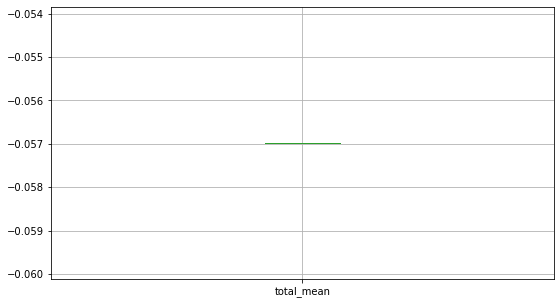

In [16]:
boxplot = df_cities_neg.boxplot(column=['total_mean'], grid=True, figsize=(9, 5))

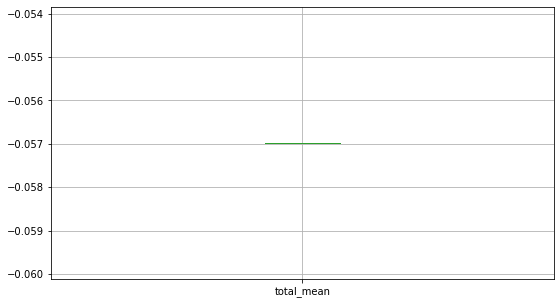

In [17]:
boxplot = df_cities_pos.boxplot(column=['total_mean'], grid=True, figsize=(9, 5))

**Gráfico de Barras**

In [18]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Cidades com **menores médias** de sentimentos

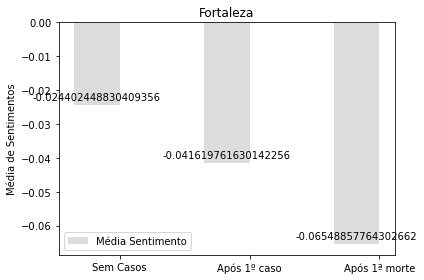

In [19]:
for index, row in df_cities_neg.iterrows():
    
    city = row['city']
    mean1 = row['periodo1_mean']
    mean2 = row['periodo2_mean']
    mean3 = row['periodo3_mean']

    labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
    y1 = [mean1, mean2, mean3]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Média de Sentimentos')
    ax.set_title(city)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1)

    fig.tight_layout()

    plt.show()

Cidades com **maiores médias** de sentimentos

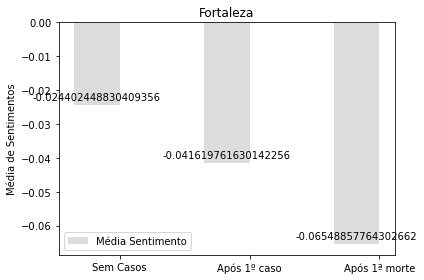

In [20]:
for index, row in df_cities_pos.iterrows():
    
    city = row['city']
    mean1 = row['periodo1_mean']
    mean2 = row['periodo2_mean']
    mean3 = row['periodo3_mean']

    labels = ['Sem Casos', 'Após 1º caso', 'Após 1ª morte']
    y1 = [mean1, mean2, mean3]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y1, width, label='Média Sentimento', color='gainsboro')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Média de Sentimentos')
    ax.set_title(city)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    autolabel(rects1)

    fig.tight_layout()

    plt.show()

**Média de sentimento por dia**

In [21]:
def generate_daily_graphic(df, df_brasil):
    
    for index, row in df.iterrows():
    
        city = row['city']
        first_case_date = row['first_case_date']
        first_death_date = row['first_death_date']

        df_city = df_brasil.query('city == "'+city+'"')
        df_scores_city = fresults.building_dates_df(df_city, 'score')

        x = df_scores_city.created_at
        y = df_scores_city.score_mean

        color = 'dimgrey'

        label = 'Médias'
        xLabel = 'Data'
        yLabel = 'Médias'

        title = city

        fresults.generate_graphic_cases(x, y, label, color, xLabel, yLabel, title, '2020-02-01', first_case_date, first_death_date)

Cidades com **menores médias** de sentimentos

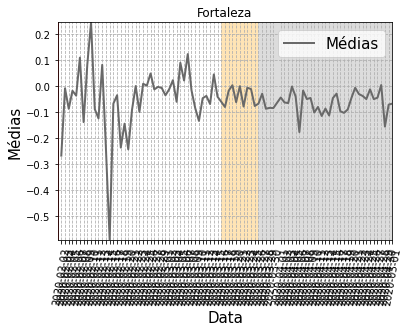

In [22]:
generate_daily_graphic(df_cities_neg, df)

Cidades com **maiores médias** de sentimentos

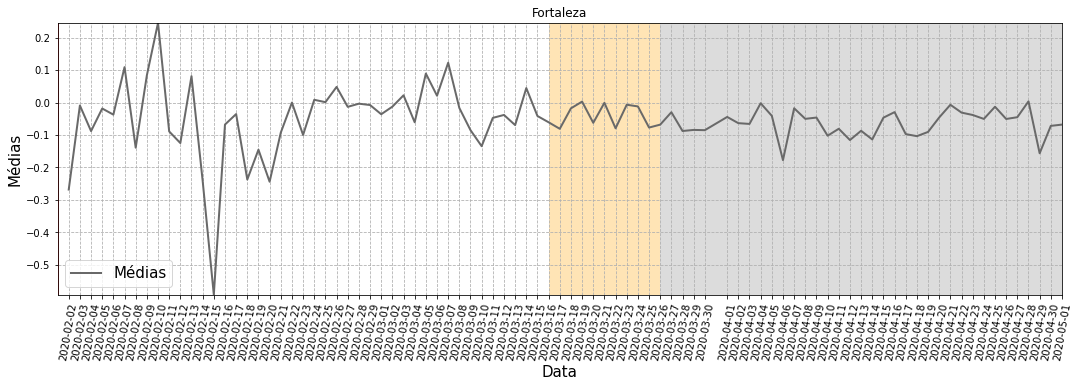

In [23]:
generate_daily_graphic(df_cities_pos, df)

**Palavras presentes nos tweets que mais influenciaram negativamente/positivamente**

Primeiro Período (Sem Casos)

- Cidades com menores médias de sentimentos

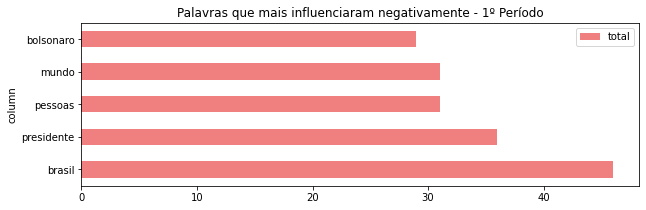

In [24]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg1')
fresults.generate_bar_from_tokens_freq(all_tokens_neg, 'lightcoral', 10, 3, title)

- Cidades com maiores médias de sentimentos

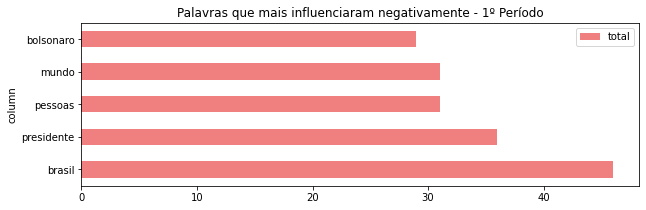

In [25]:
title = 'Palavras que mais influenciaram negativamente - 1º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg1')
fresults.generate_bar_from_tokens_freq(all_tokens_neg, 'lightcoral', 10, 3, title)

- Cidades com menores médias de sentimentos

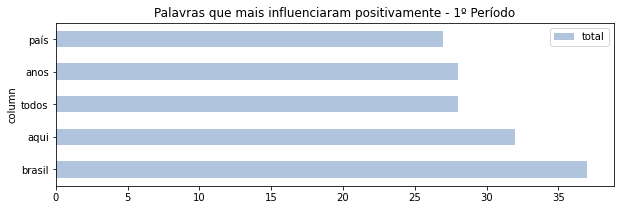

In [26]:
title = 'Palavras que mais influenciaram positivamente - 1º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos1')
fresults.generate_bar_from_tokens_freq(all_tokens_pos, 'lightsteelblue', 10, 3, title)

- Cidades com maiores médias de sentimentos

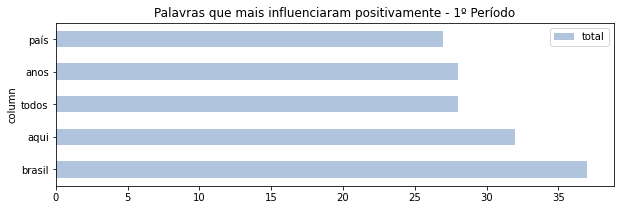

In [27]:
title = 'Palavras que mais influenciaram positivamente - 1º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos1')
fresults.generate_bar_from_tokens_freq(all_tokens_pos, 'lightsteelblue', 10, 3, title)

Segundo Período (Após 1º caso)

- Cidades com menores médias de sentimentos

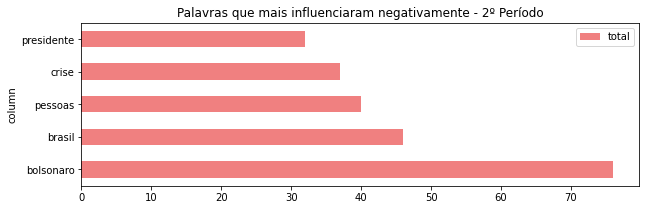

In [28]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg2')
fresults.generate_bar_from_tokens_freq(all_tokens_neg, 'lightcoral', 10, 3, title)

- Cidades com maiores médias de sentimentos

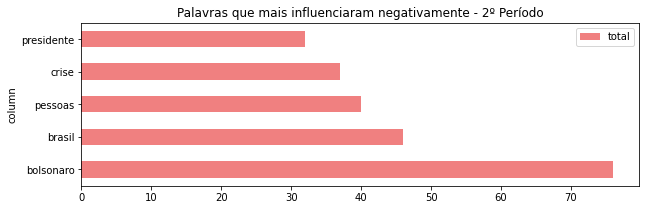

In [29]:
title = 'Palavras que mais influenciaram negativamente - 2º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg2')
fresults.generate_bar_from_tokens_freq(all_tokens_neg, 'lightcoral', 10, 3, title)

- Cidades com menores médias de sentimentos

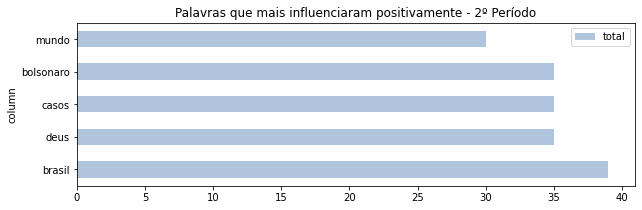

In [30]:
title = 'Palavras que mais influenciaram positivamente - 2º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos2')
fresults.generate_bar_from_tokens_freq(all_tokens_pos, 'lightsteelblue', 10, 3, title)

- Cidades com maiores médias de sentimentos

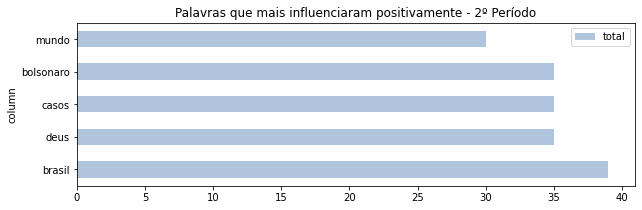

In [31]:
title = 'Palavras que mais influenciaram positivamente - 2º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos2')
fresults.generate_bar_from_tokens_freq(all_tokens_pos, 'lightsteelblue', 10, 3, title)

Terceiro Período (Após 1ª morte)

- Cidades com menores médias de sentimentos

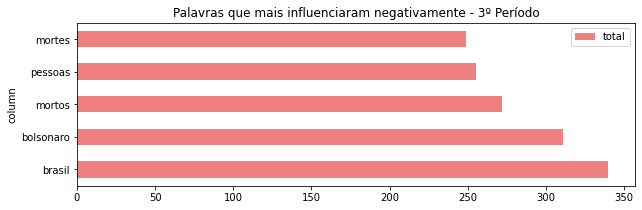

In [32]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
all_tokens_neg = return_tokens(df_cities_neg, 'tokens_neg3')
fresults.generate_bar_from_tokens_freq(all_tokens_neg, 'lightcoral', 10, 3, title)

- Cidades com maiores médias de sentimentos

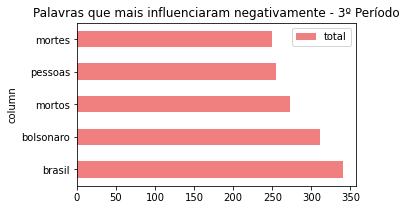

In [33]:
title = 'Palavras que mais influenciaram negativamente - 3º Período'
all_tokens_neg = return_tokens(df_cities_pos, 'tokens_neg3')
fresults.generate_bar_from_tokens_freq(all_tokens_neg, 'lightcoral', 10, 3, title)

- Cidades com menores médias de sentimentos

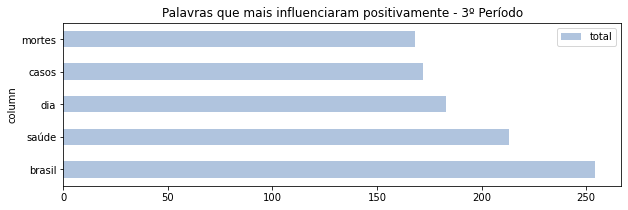

In [34]:
title = 'Palavras que mais influenciaram positivamente - 3º Período'
all_tokens_pos = return_tokens(df_cities_neg, 'tokens_pos3')
fresults.generate_bar_from_tokens_freq(all_tokens_pos, 'lightsteelblue', 10, 3, title)

- Cidades com maiores médias de sentimentos

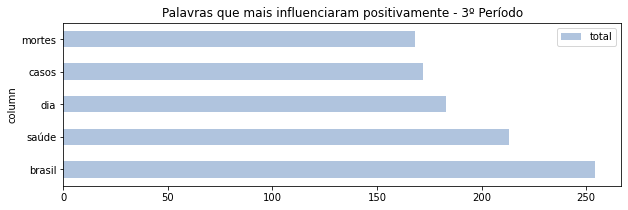

In [35]:
title = 'Palavras que mais influenciaram positivamente - 3º Período'
all_tokens_pos = return_tokens(df_cities_pos, 'tokens_pos3')
fresults.generate_bar_from_tokens_freq(all_tokens_pos, 'lightsteelblue', 10, 3, title)